# Final Project: Bootstrapping Method

#### Name: Carlos Cocha
Erasmus Mundus JMD on Nuclear Physics, Faculty of Physics, Universidad de Sevilla

##### Computing & Numerical Methods

##  Bootstrapping method to calculate properties of fitting parameters

This first part of the project is focused to compare the main differences between both, the weighted and the unweighted fittings, using the Bootstraping method. 

#### Loading the required packages and functions

In [1]:
import statistics
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
def average(x, w = False, ws = []):
    '''
    Function to calculate the average (weighted average if w = True) of x.
    
    Parameters:
    x     :: set of data
    ws    :: set of weights
    
    Example:
    average([2,5,4,5,7], [0.5,0.2,0.4,0.5,0.3],  w = True)
    - 5.07887
    '''
    if w == True: 
        x_w = np.sum(x*ws)/np.sum(ws)
    else:
        x_w = np.sum(x)/len(x)
    return x_w

In [3]:
def slope_inter(x, y, w = False, ws = [], resid = False):
    '''
    Function to calculate the intercept (y0) and the slope (m) parameters of
    y = y0 + m*x or y = y0 + m*[x-x^](if w = True)  given  2 sets of data (x, y). 
    
    Parameter:
    x :: set of data x
    y :: set of data y
    ws:: set of weights
    w :: if True, calculate the weighted fitting parameters
    resid :: if True, it returns the mean of the sum of the square residues.
    
    Example:
    slope_inter([0.5 , 0.9 , 1.5 , 1.8 , 2.65], [2.4 , 3.1 , 4.7 , 4.9 , 6.3])
    (4.279999999999999, 1.8414017341040463)
    '''
    numerator = 0
    denominator = 0
    
    if w == True:
        x_m =  average(x, w = True, ws = ws)
        y_m = average(y, w = True, ws = ws)

        numerator = np.sum(ws*(x-x_m)*(y-y_m))
        denominator = np.sum(ws*(x-x_m)*(x-x_m))
        m = numerator/denominator #slope
        y0 = y_m                  #interception
        if resid == True:
            # weighted mean square residues
            res = average((y -(y0 + m*(x-x_m)))**2, w = True, ws = ws)
            return y0 , m, res
        else:
            return y0 , m
    else:
        x_m = average(x)
        y_m = average(y)
        
        numerator = np.sum((x-x_m)*(y-y_m))
        denominator = np.sum((x-x_m)*(x-x_m))
        m = numerator/denominator  #slope
        y0 = y_m - m*x_m           #interception
        if resid == True:
            res = average((y -(y0 + m*np.array(x)))**2) #residue
            return y0 , m, res
        else:
            return y0 , m

In [4]:
def cov(array1, array2):
    '''
    Function to calculate de covariance of 2 datasets.
    
    Parameters:
    array1 :: set of data1
    array2 :: set of data2
    
    Example:
    cov([1, 2, 4, 6, 3], [3, 5, 3, 2, 7])
    -1.5    
    '''
    n = 0
    M = len(array1)
    a1_m = np.array(array1).mean()
    a2_m = np.array(array2).mean()
    for i in range(M):
        n += (array1[i] - a1_m)*(array2[i] - a2_m)
    covariance = n/(M-1)
    return covariance

In [5]:
def stand_d(x):
    '''
    Function to calculate the standard deviation of a set x.
    
    Parameters:
    x :: set of data
    
    Example:
    stand_d([2,5,2,4,5,7,3])
    1.82574
    '''
    x_m = np.mean(x)
    n = 0
    for i in range(len(x)):
        n += (x[i] - x_m)**2
    sd = np.sqrt(n/(len(x) - 1))
    return sd

In [6]:
def stand_dm(x):
    '''
    Function to calculate the standard deviation of the mean of x.
    
    Parameters:
    x :: set of data
    
    Example:
    stand_d([2,5,2,4,5,7,3])
    0.690065
    '''

    sdm = stand_d(x)/np.sqrt(len(x))
    return sdm

In [7]:
def pearson(x, y, w = False, ws = []):
    '''
    Function to calculate the Pearson’s r coefficient given x and y data.
    
    Parameters:
    x :: set of data
    y :: set of data
    ws = set of weights 
    w = if True, calculate the Pearson’s r value for the weighted fitting.
    
    Example:
    pearson(x, y, w = True, ws = 1/sy**2)
    0.99463
    '''
    if w == True:
        n = np.sum(ws)*np.sum(ws*x*y)-np.sum(ws*x)*np.sum(ws*y)
        d = np.sqrt(np.sum(ws)*np.sum(ws*x*x)-(np.sum(ws*x))**2)*np.sqrt(np.sum(ws)*np.sum(ws*y*y)-(np.sum(ws*y))**2)
        r = n/d
    else:
        sx = np.sqrt(np.sum((x-average(x))**2)/(len(x)-1))
        sy = np.sqrt(np.sum((y-average(y))**2)/(len(y)-1))
        n = cov(x, y)
        d = sx*sy
        r = n/d
    return r    

In [8]:
def plot_histo(data_tm, xlabel, ax = None, **plt_kwargs):
    '''
    Function to plot the histograms with  their main properties
    
    Parameters:
    data_tm :: set of data
    xlabel  :: label for the x axis 
    ax      :: parameter in which the histogram is stored  
    '''
    ax.hist(data_tm, bins=50, range=[min(data_tm), max(data_tm)], fc = 'none',
            histtype = 'step', color = 'black', label = xlabel+' = '+str(round(average(data_tm), 4))+
            ' $\pm$ ' +str(round(stand_dm(data_tm), 4)), linewidth = .8)
    ax.legend(loc = 'lower right')
    ax.set_xlabel(xlabel, size = 10 )
    ax.set_ylabel('amplitude', size = 10)
    return ax

### 1. Read the data: x𝑖 ± 𝜎x𝑖, y𝑖 ± 𝜎y𝑖

In [9]:
# Reading the data from a .csv file
data = pd.read_csv("DATA.csv")
headers = ['x','y','sigma_x','sigma_y']
dframe = pd.DataFrame(data.values, columns = headers)
dframe

x      y  sigma_x  sigma_y
0  0.50   2.40     0.02      0.6
1  0.90   3.10     0.09      1.8
2  1.50   4.70     0.15      1.5
3  1.80   4.90     0.18      0.6
4  2.65   6.30     0.45      3.0
5  3.00   8.05     0.05      0.2
6  3.45   8.80     0.07      0.4
7  4.10  11.50     0.25      3.2
8  4.65  11.20     0.15      0.8
9  5.25  14.30     0.25      2.4

In [10]:
# Copying the data into variables 
x = dframe['x']
y = dframe['y']
sx = dframe['sigma_x']
sy = dframe['sigma_y']

### 2. Obtain up to M = 1000 sets of datapoints {{𝑥𝑖, 𝑦𝑖} k} 𝑖  = 1, …, 𝑁,  𝑘 = 1, …, 𝑀 by resampling from your experimental data. Use the generator producing random numbers with Gaussian distribution

In [11]:
M = 10000
resampling = [] # to save all the resampling data
for i in range(M):
    x_d , y_d = [] , []
    for j in range(len(x)):
        # random.randn produce random numbers with Gaussian distribution
        x_d.append(x[j] + sx[j]*np.random.randn())
        y_d.append(y[j] + sy[j]*np.random.randn())
    resampling.append([x_d, y_d])

### 3. For each artificially resampled dataset, calculate their own slope and intercept (do NOT calculate their errors here!).

In [12]:
y0_m_dat = np.zeros((M, 2))  # to save the unweighted fitting parameters
y0_mw_dat = np.zeros((M, 2)) # to save the weighted fitting parameters
for i in range(M):
    # Calculate the slope and interception of each resampling dataset.
    y0_m_dat[i][0], y0_m_dat[i][1] = slope_inter(resampling[i][0], resampling[i][1])
    # For the weighted fitting w = True
    y0_mw_dat[i][0], y0_mw_dat[i][1] = slope_inter(resampling[i][0], resampling[i][1],  w = True, ws = 1/(sy**2))

### 4. Once the loop is finished, provide as output: y0 ± 𝜎y0 and m ± 𝜎m using the mean and standard deviation of the mean of the y0𝑘, m𝑘𝑘 = 1𝑀 values obtained.

In [13]:
# Results fot the unweighted fitting
y0_m = y0_m_dat[:, 0].mean()
m_m = y0_m_dat[:, 1].mean()
sd_y0 = stand_dm(y0_m_dat[:, 0])
sd_m = stand_dm(y0_m_dat[:, 1])
print('The results using y = y0 + m*x fitting are:')
print('y0 ± 𝜎y0 = ' + str(round(y0_m, 4)) +  " ± " + str(round(sd_y0, 4)))
print('m  ± 𝜎m  = ' + str(round(m_m, 4)) +  " ± " + str(round(sd_m, 4)))
cov_y0_m = cov(y0_m_dat[:, 0], y0_m_dat[:, 1])
print("cov(y0, m) =", str(round(cov_y0_m, 2)))

The results using y = y0 + m*x fitting are:
y0 ± 𝜎y0 = 0.872 ± 0.0099
m  ± 𝜎m  = 2.3945 ± 0.0038
cov(y0, m) = -0.31


In [14]:
# Results fot the weighted fitting
y0_mw = y0_mw_dat[:, 0].mean()
m_mw = y0_mw_dat[:, 1].mean()
sd_y0w = stand_dm(y0_mw_dat[:, 0])
sd_mw = stand_dm(y0_mw_dat[:, 1])
print('The results using y = y0 + m*(x - x0) fitting are:')
print('y0 ± 𝜎y0 = ' + str(round(y0_mw, 4)) +  " ± " + str(round(sd_y0w, 4)))
print('m  ± 𝜎m  = ' + str(round(m_mw, 4)) +  " ± " + str(round(sd_mw, 4)))
cov_y0_mw = cov(y0_mw_dat[:, 0], y0_mw_dat[:, 1])
print("cov(y0, m) =", str(round(cov_y0_mw, 4)))

The results using y = y0 + m*(x - x0) fitting are:
y0 ± 𝜎y0 = 7.63 ± 0.0016
m  ± 𝜎m  = 2.2283 ± 0.0019
cov(y0, m) = 0.0001


#### Contour plot between m and y0:

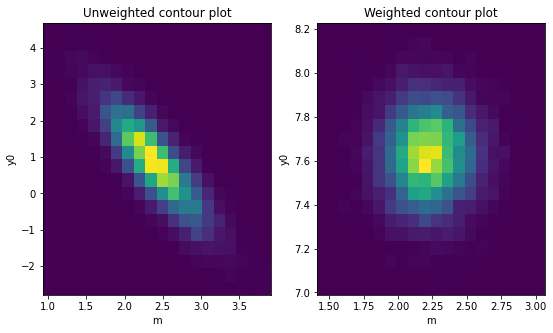

In [15]:
fig = plt.figure(figsize=(9,5))
gs = GridSpec(1,2) # 1 rows, 2 columns
ax1 = fig.add_subplot(gs[0,0])
ax1.hist2d(y0_m_dat[:, 1], y0_m_dat[:, 0], bins = 20)
ax2 = fig.add_subplot(gs[0,1])
ax2.hist2d(y0_mw_dat[:, 1], y0_mw_dat[:, 0], bins = 20)
ax1.set_title('Unweighted contour plot')
ax2.set_title('Weighted contour plot')
ax1.set_xlabel("m")
ax1.set_ylabel('y0')
ax2.set_xlabel("m")
ax2.set_ylabel('y0')
plt.show()

By definition, covariance measures the total variation of two random variables from their expected values. A covariance equal to 0 means that the two variables are independent each other (no linear tendency), as is observed in the weighted contour plot. But, for the unweighted contour plot a linear dependence is observed.Which make sense because y0 and m are least-squares regression parameters (y0 = 𝑦 − m*𝑥), that define the straight line that maximizes the amount of variation in y that can be explained by a linear regression on x. So, y0 and m are not independent of each other for the unweighted case but not for the weighted case.

Also, using the covariance value allow us to estimate the direction of the relationship (whether the variables tend to move in tandem). According to the unweighted calculations the cov(y0, m) < 0 which means that y0 and m coefficientes tend to move in the opposite directions (increase in y0 corresponds a decrease in m).

### 1D frequency histograms of {y0_𝑘}𝑘 = 1, ..., 𝑀 and {m_𝑘} 𝑘 = 1, ..., 𝑀.

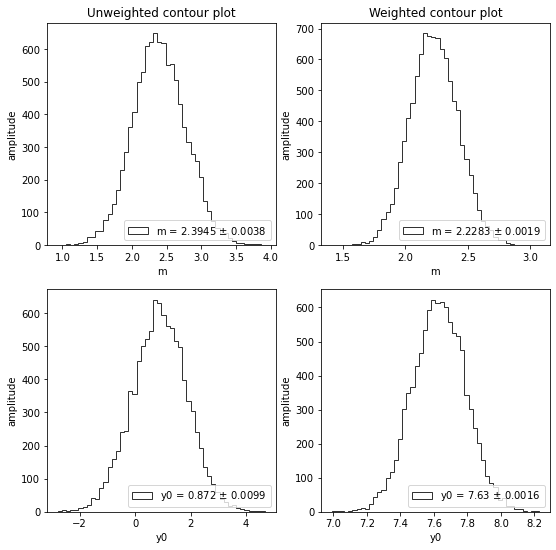

In [16]:
fig = plt.figure(figsize=(9,9))
gs = GridSpec(2,2) # 1 rows, 2 columns
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
plot_histo(y0_m_dat[:, 1],"m", ax1)
plot_histo(y0_mw_dat[:, 1],"m", ax2)
plot_histo(y0_m_dat[:, 0],"y0", ax3)
plot_histo(y0_mw_dat[:, 0],"y0", ax4)
ax1.set_title('Unweighted contour plot')
ax2.set_title('Weighted contour plot')
plt.show()

### 5. Plot your experimental datapoints ( including errorbars ) with the result of this linear regression.

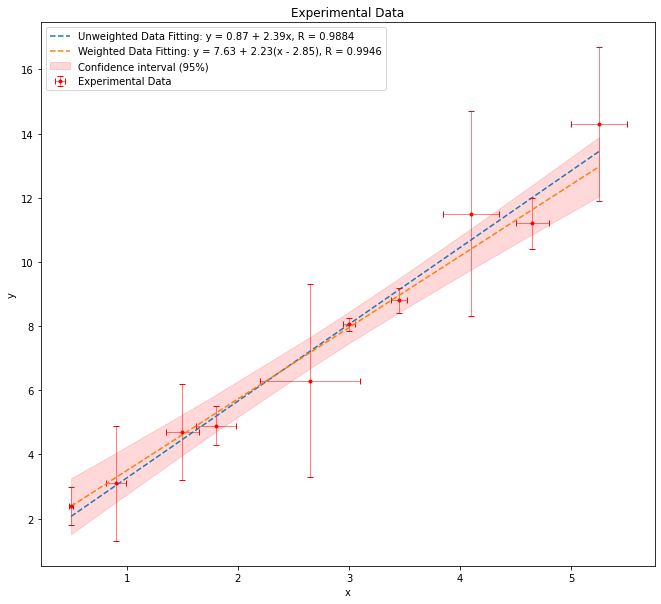

In [17]:
# Create a plot environment
fig, ax = plt.subplots(figsize = (11, 10))
# Boostrapping unweighted data fitting plot
yfit = y0_mw + m_mw*np.array(x-average(x, w = True, ws = 1/(sy*sy)))
plt.plot(x, y0_m + m_m*np.array(x), "--", label = "Unweighted Data Fitting: y = "+str(round(y0_m, 2))+
         ' + '+str(round(m_m, 2))+'x, R = '+ str(round(pearson(x, y),4)))
plt.errorbar(x,y, xerr = sx, yerr = sy, fmt = 'ro', markersize = 3, 
             ecolor = 'red', capsize = 3,  linewidth = 0.5, 
             color = 'darkblue', label = "Experimental Data")
# Boostrapping weighted data fitting plot
plt.plot(x, yfit, "--", label = "Weighted Data Fitting: y = "+str(round(y0_mw, 2))+' + '+str(round(m_mw, 2))+
         '(x - '+str(round(average(x, w = True, ws = 1/(sy*sy)),2))+'), R = '+
         str(round(pearson(x, y, w= True, ws = 1/(sy*sy)),4)))
# Confidence interval plot
#resid = y - yfit)
s_err = stand_d(y - yfit)
t = stats.t.ppf(0.975, len(x)-1) # t = 0.975 for 95 % of confidence
ci = t * s_err * np.sqrt(1/len(x) + (x - np.mean(x))**2/np.sum((x-np.mean(x))**2))    
plt.fill_between(x, yfit + ci, yfit - ci, color=[1, 0, 0, 0.15], label = "Confidence interval (95%)") 

plt.xlabel('x')
plt.ylabel('y')
plt.title('Experimental Data')
plt.legend()
plt.show()

### Plot of (x0 - x_hat) and 𝑦0 - 𝑦_hat) as function of the number of resamplings 𝑀 as well as the mean of the sum of squared residuals e^2

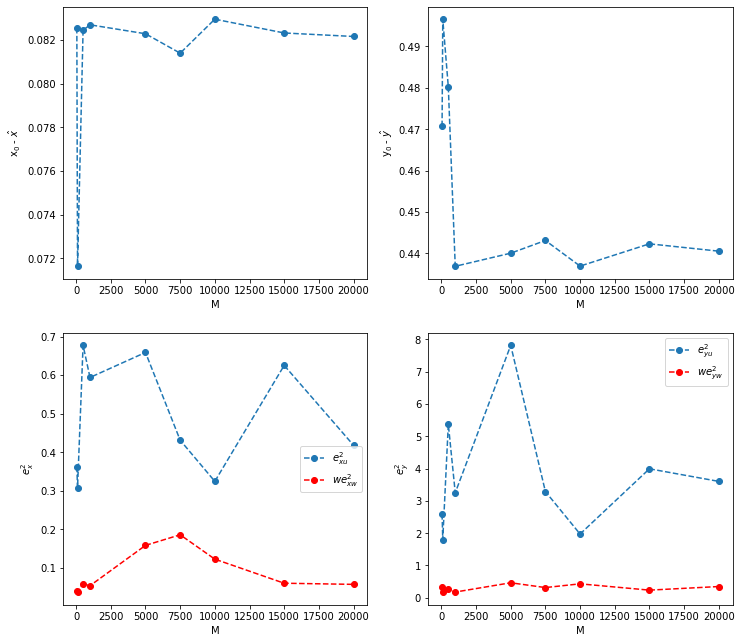

In [24]:
Ms = [50, 100,500, 1000, 5000, 7500, 10000, 15000, 20000]
y0s = []
x0s = []
res_xut, res_xwt, res_yut, res_ywt = [], [], [], []
for k in Ms:
    x_hat, y_hat = [], []
    for i in range(k):
        x_d , y_d = [] , []
        res_xu, res_xw, res_yu, res_yw = [], [], [], []
        for j in range(len(x)):
            # random.randn produce random numbers with Gaussian distribution
            x_d.append(x[j] + sx[j]*np.random.randn())
            y_d.append(y[j] + sy[j]*np.random.randn())
        # Calculate the difference for each resampling dataset.
        y_hat.append(np.abs(average(y_d) - average(y_d,  w = True, ws = 1/(sy*sy))))
        x_hat.append(np.abs(average(x_d) - average(x_d,  w = True, ws = 1/(sy*sy))))
        # Calculate the mean of the sum of squared residuals for each resampling dataset.
        y0_bu, m_bu, ry0_bu = slope_inter(x_d, y_d, resid = True) # y = y0 + m(x - x0)
        x0_bu, m_bu, rx0_bu = slope_inter(y_d, x_d, resid = True) # x = x0 + m^-1(y - y0)
        y0_bw, m_bw, ry0_bw = slope_inter(x_d, y_d,  w = True, ws = 1/(sy*sy), resid = True ) # y = y0 + m(x - x0)
        x0_bw, m_bw, rx0_bw = slope_inter(y_d, x_d,  w = True, ws = 1/(sx*sx), resid = True) # x = x0 + m^-1(y - y0
        res_xu.append(rx0_bu)
        res_xw.append(rx0_bw)
        res_yu.append(ry0_bu)
        res_yw.append(ry0_bw)
    y0s.append(average(y_hat))
    x0s.append(average(x_hat))
    res_xut.append(average(res_xu))
    res_xwt.append(average(res_xw))
    res_yut.append(average(res_yu))
    res_ywt.append(average(res_yw))

fig = plt.figure(figsize=(12, 11))
gs = GridSpec(2,2) # 1 rows, 2 columns
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax1.plot(Ms, x0s, "o--")
ax2.plot(Ms, y0s, "o--")
ax3.plot(Ms, res_xut, "o--", label = '$e^2_{xu}$') 
ax3.plot(Ms, res_xwt, "or--", label = '$we^2_{xw}$') 
ax4.plot(Ms, res_yut, "o--", label = '$e^2_{yu}$')
ax4.plot(Ms, res_ywt, "or--", label = '$we^2_{yw}$')
ax1.set_xlabel('M')
ax2.set_xlabel('M')
ax3.set_xlabel('M')
ax4.set_xlabel('M')
ax1.set_ylabel('x$_0$ - $\hat{x}$') 
ax2.set_ylabel('y$_0$ - $\hat{y}$')
ax3.set_ylabel('$e^2_x$')
ax4.set_ylabel('$e^2_y$')
ax3.legend()
ax4.legend()
plt.show()

### Include 𝑥0 as fitting parameter instead of using  𝑥_hat as prefixed value. Study the convergence in this case of 𝑥0 to 𝑥_hat, and of 𝑦0 to 𝑦_hat, as function of the number of point resamplings 𝑀

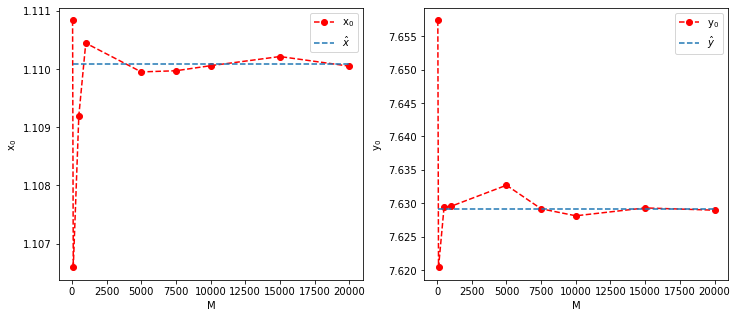

In [20]:
Ms = [50, 100,500, 1000, 5000, 7500, 10000, 15000, 20000]
y0s, x0s = [], []
for k in Ms:
    x_hat, y_hat = [], []
    for i in range(k):
        x_d , y_d = [] , []
        for j in range(len(x)):
            # random.randn produce random numbers with Gaussian distribution
            x_d.append(x[j] + sx[j]*np.random.randn())
            y_d.append(y[j] + sy[j]*np.random.randn())
        # Calculate the difference for each resampling dataset.
        y0_bw, m_bw = slope_inter(x_d, y_d,  w = True, ws = 1/(sy*sy)) 
        x0_bw, m_bw = slope_inter(y_d, x_d,  w = True, ws = 1/(sx*sx)) 

        y_hat.append(y0_bw)
        x_hat.append(x0_bw)   
    y0s.append(average(y_hat))
    x0s.append(average(x_hat))

fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1,2) # 1 rows, 2 columns
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

ax1.plot(Ms, x0s, "or--", label = 'x$_0$')
ax2.plot(Ms, y0s, "or--", label='y$_0$')
ax1.plot(Ms, [average(x,  w = True, ws = 1/(sx*sx))for i in range(len(Ms))], "--",  label ='$\hat{x}$')
ax2.plot(Ms, [average(y,  w = True, ws = 1/(sy*sy)) for i in range(len(Ms))], "--", label ='$\hat{y}$')
ax1.set_xlabel('M')
ax2.set_xlabel('M')
ax1.set_ylabel('x$_0$')
ax2.set_ylabel('y$_0$')
ax1.legend()
ax2.legend()
plt.show()

# Bootstrapping Method for Emittance uncertainty calculation

#### SUMMARY
This part of the project is devoted to using the Bootstrapping Method to calculate the uncertainties in the experimental calculation of the beam emittance of an electron beam with an energy of 147.8 MeV. There are two ways to calculate the emittance, one is by matrix multiplication (Transfer Matrix - TM) method and the other is by doing an approximation called Thin Lens (TL) Approximation, where the experimental data can be fitted by a quadratic parabola. Thanks to the quadratic fitting parameters, the TL method will be divided into the unweighted Thin Lens (TLW) approximation and  Weighted Thin Lens (TLW) approximation.

#### Loading the required packages 

In [2]:
import statistics
import numpy as np
import pandas as pd
from time import time
from random import seed
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

#### First, reading the raw data and displaying them in a dataframe.

In [3]:
I_meas, sigm = np.loadtxt('2_medida_emittance_planeX_E_147.8_MULTIBUNCH.txt', skiprows=2, unpack=True)
current, err_current, sigma,err_sigma  = [],[],[],[]
for i in range(0, len(I_meas), 4):
    current.append(np.mean(I_meas[i:i+4]))
    err_current.append(np.std(I_meas[i:i+4]))
    sigma.append(np.mean(sigm[i:i+4]))
    err_sigma.append(np.std(sigm[i:i+4]))
Data = pd.DataFrame({' Current [A]':current,
                     '$\pm$ uncert. [A]': err_current,
                     'Beam size [mm]':np.array(sigma)*1000, 
                     '$\pm$ uncert. [mm]': np.array(err_sigma)*1000})
Data

Current [A]  $\pm$ uncert. [A]  Beam size [mm]  $\pm$ uncert. [mm]
0       0.599469           0.000463        0.841789            0.000379
1       0.680176           0.000608        0.810870            0.000358
2       0.759980           0.000768        0.781524            0.000427
3       0.839422           0.000189        0.759312            0.000159
4       0.919748           0.000872        0.746339            0.000348
5       0.999935           0.000570        0.738818            0.000750
6       1.079443           0.000543        0.742549            0.000190
7       1.160010           0.000788        0.753461            0.007116
8       1.240282           0.000468        0.763682            0.000262
9       1.319938           0.000763        0.797372            0.000028
10      1.399743           0.000333        0.836072            0.000262

### Setting the experimental set-up data

In [4]:
I2K1 = [-0.0089, 2.1891, 0.0493] # Fitting values to transform from I to K
DIST = 2.8775                    # Space between the quadrupole and the camera
QUAD_L = 0.112                   # Quadrupole length
light_speed = 299792458          # in m/s
electron_rest_en = 0.5109989461  # in MeV
energy = 147.8                   # beam energy in MeV

### Loading the necessary functions

In [5]:
def _get_K1_from_I(energy, current):
    '''
    Function to calculate the quadrupole strength using the quadrupole current.
    
    -Parameters:
    energy  :: energy of the beam
    current :: quadrupole current
    '''
    kin_en = np.sqrt(energy*energy - electron_rest_en*electron_rest_en)
    return np.polyval(I2K1, current)*light_speed/kin_en/1e6

In [6]:
def _twiss(s_11 , s_12, s_22, energy):
    '''
    Funtion to calculate the normalize emittance and the 
    twiss parameters using the components of the emittance matrix
    
    -Parameters:
    s_11  :: emit*beta value 
    s_12  :: -emit*alpha value 
    s_22  :: emit*gamma value 
    energy:: energy of the beam
    '''
    emit = np.sqrt(abs(s_11 * s_22 - s_12 * s_12))
    beta = s_11 / emit
    alpha = -s_12 / emit
    gamma = s_22 / emit
    nemit = emit * energy / electron_rest_en * 1e6  # in mm.mrad
    return nemit, beta, alpha, gamma

In [7]:
def _trans_matrix_method(energy, current, sigma, pl='x'):
    '''
    Function to calculate the beam emittance using the Transfer Matrix Method.
    
    -Parameters:
    energy :: energy of the beam
    current:: quadrupole current
    sigma  :: experimental beam size 
    pl     :: emittance plane
    '''
    K1 = _get_K1_from_I(energy,current)
    Rx, Ry = _get_resp_mat(K1, energy)
    R = Rx if pl == 'x' else Ry
    pseudo_inv = np.dot(np.linalg.inv(np.dot(np.transpose(R) , R)) , np.transpose(R))
    [s_11, s_12, s_22] = pseudo_inv @ (sigma*sigma)
    #s_11, s_12, s_22 = np.linalg.lstsq(R, sigma * sigma, rcond=None)[0]
    nemit, beta, alpha, gamma = _twiss(s_11, s_12, s_22, energy)
    return nemit, beta, alpha, gamma

In [8]:
def quadratic_fit(x, y, weighted = False, ws = [], correlation = False):
    '''
    Function to calculate the quadratic fitting parameters 
    of the y = a + b*x + c*x^2 parabola.
    -Parameters:
    x :: array 
    y :: array
    ws         :: weights of y
    weighted   :: if True, calculate the weighted fit. parameters
    correlation:: if True, calculate the coefficient of determination 
    '''
    x = np.array(x)
    y = np.array(y)
    x2 = x*x
    x_m = np.mean(x)
    y_m = np.mean(y)
    x2_m = np.mean(x2)
    
    if weighted == True:
        c, b, a = np.polyfit(x, y, 2, w = ws)
        y_m = np.sum(ws*y)/np.sum(ws)
    else:
        sxx, sxy, sxx2, sx2x2, sx2y = 0, 0, 0, 0, 0

        for i in range(len(x)): 
            sxx += (x[i] - x_m)**2 
            sxy += (x[i] - x_m)*(y[i] - y_m) 
            sxx2 += (x[i] - x_m)*(x2[i] - x2_m) 
            sx2x2 += (x2[i] - x2_m)**2 
            sx2y += (x2[i] - x2_m)*(y[i] - y_m)  

        b = (sxy*sx2x2-sx2y*sxx2)/(sxx*sx2x2-sxx2*sxx2)
        c = (sx2y*sxx-sxy*sxx2)/(sxx*sx2x2-sxx2*sxx2)
        a = y_m - b*x_m - c*x2_m
    
    #coefficient of determination calculation
    n, d = 0, 0
    for i in range(len(x)):
        n += (y[i] - (a + b*x[i]+c*x[i]*x[i]))**2
        d += (y[i]- y_m)**2
    r = np.sqrt(1-n/d)
    
    if correlation == True:
        return  a, b, c, r
    else: 
        return  a, b, c  

In [9]:
def _thin_lens_method(energy, current, sigma, pl='x', weighted = 'False', error=[]):
    '''
    Function to calculate the beam emittance using the thin lens approximation 
    method with quadratic fitting parameters.
    
    -Parameters:
    energy  :: energy of the beam
    current :: quadrupole current
    sigma   :: beam size
    pl      :: plane of the emittance
    weighted:: if True, use the weighted fitting parameters
    error   :: error of the beam size
    '''
    I2 = current if pl == 'x' else -current
    K1 = _get_K1_from_I(energy, I2) #quadrupole strenght
    
    if weighted == 'True':
        c, b, a = quadratic_fit(K1, sigma*sigma, weighted=True, ws = 1/(2*np.array(error))**2)
    else:
        c, b, a = quadratic_fit(K1, sigma*sigma)
    
    d = DIST + QUAD_L/2
    l = QUAD_L
    #Using the set-up parameters to calculate the emittance
    s_11 = a/(d*l)**2
    s_12 = (-b-2*d*l*s_11)/(2*l*d*d)
    s_22 = (c-s_11-2*d*s_12)/d**2
    nemit, beta, alpha, gamma = _twiss(s_11, s_12, s_22, energy)
    return nemit, beta, alpha, gamma

In [10]:
def gettransmat(type, L, gamma, K1=None, B=None):
    '''
    Function to calculate a single transfer matrix.
    
    -Parameters:
    type :: type of transfer matrix
    L    :: space between the quadrupole and the camera
    gamma:: Lorentz factor
    K1   :: quadrupole strength
    '''
    R = np.eye(6)

    if type.lower().startswith('qu') and K1 is not None and K1 == 0:
        type = 'drift'
    if type.lower().startswith('dr'):
        R = np.array([
            [1, L, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, L, 0, 0],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, L/gamma**2],
            [0, 0, 0, 0, 0, 1],
            ])
    elif type.lower().startswith('qu') and K1 is not None:
        kq = np.sqrt(abs(K1))
        c = np.cos(kq*L)
        s = np.sin(kq*L)
        ch = np.cosh(kq*L)
        sh = np.sinh(kq*L)
        if K1 > 0:
            x11, x12, x21 = c,  1/kq*s, -kq*s
            y11, y12, y21 = ch, 1/kq*sh, kq*sh
        else:
            x11, x12, x21 = ch, 1/kq*sh, kq*sh
            y11, y12, y21 = c,  1/kq*s, -kq*s
        R = np.array([
            [x11, x12, 0,   0,   0, 0],
            [x21, x11, 0,   0,   0, 0],
            [0,   0,   y11, y12, 0, 0],
            [0,   0,   y21, y11, 0, 0],
            [0,   0,   0,   0,   1, L/gamma**2],
            [0,   0,   0,   0,   0, 1],
            ])
    elif type.lower().startswith('sol') and B is not None:
        K = -light_speed*B/2.0/electron_rest_en/gamma/1e6
        C = np.cos(K*L)
        S = np.sin(K*L)
        SC = C*S
        C2 = C**2
        S2 = S**2
        R = np.array([
            [C2,    SC/K,  SC,    S2/K, 0., 0.],
            [-K*SC, C2,    -K*S2, SC,   0., 0.],
            [-SC,   -S2/K, C2,    SC/K, 0., 0.],
            [K*S2,  -SC,   -K*SC, C2,   0., 0.],
            [0.,    0.,    0.,    0.,   1., L/(gamma**2)],
            [0.,    0.,    0.,    0.,   0., 1.]
            ])
    return R

In [11]:
def _get_resp_mat(K1, energy):
    '''
    Function to calculate the total transfer matrix of the experiment.
    
    -Parameters:
    K1     :: quadrupole strength 
    energy :: energy of the beam
    '''
    gamma = energy/electron_rest_en
    R = np.zeros((len(K1), 6, 6))
    Rd = gettransmat('drift', L=DIST, gamma=gamma)
    for i, k1 in enumerate(K1):
        Rq = gettransmat('quad', L = QUAD_L, gamma=gamma, K1=k1)
        R[i] = np.dot(Rd, Rq)
    R11 = R[:, 0, 0].reshape(-1, 1)
    R12 = R[:, 0, 1].reshape(-1, 1)
    R33 = R[:, 2, 2].reshape(-1, 1)
    R34 = R[:, 2, 3].reshape(-1, 1)
    Rx = np.column_stack((R11*R11, 2*R11*R12, R12*R12))
    Ry = np.column_stack((R33*R33, 2*R33*R34, R34*R34))
    return Rx, Ry

In [12]:
def plot_histo(data_tm, data_tl, data_tlw, xaxis = None, ax = None, **plt_kwargs):
    '''
    Function to plot three histograms together and display their main properties
    like the mean +/- standard error of the mean.
    
    - Parameters:
    data_tm :: data set 
    data_tl :: data set
    data_tlw:: data set
    xaxis   :: Label for the axes x
    ax      :: variable to plot the histogram
    '''

    ax.hist(data_tm, bins=50, range=[min(data_tm), max(data_tm)], fc='none',
            histtype='step', color='black', label='TM, $\mu$: '+str(round(data_tm.mean(),3))+', $\sigma$: '+
             str(round( np.std(data_tm), 3)), linewidth=.8)
    
    ax.hist(data_tl, bins=50, range=[min(data_tl), max(data_tl)],  fc='none',
            histtype='step', color = 'maroon', label='TL, $\mu$: '+str(round(data_tl.mean(),3))+', $\sigma$: '+
             str(round( np.std(data_tl), 3)), linewidth=.8)

    ax.hist(data_tlw, bins=50, range=[min(data_tlw), max(data_tlw)], fc='none',
            histtype='step', color = 'steelblue', label='TLW, $\mu$: '+str(round(data_tlw.mean(),3))+', $\sigma$: '+
             str(round(np.std(data_tlw), 3)), linewidth=.8)
    
    ax.legend(loc='lower right')
    ax.set_xlabel(xaxis, x=1, ha='right',size= 10 )
    ax.set_ylabel('amplitude', y=1, ha='right',size= 10)
    return ax

In [13]:
def emit_montec(energy, sigma, err_s, I, err_I, plane, M, plot = True, times = False):
    '''
    Main function to resample the raw data and calculate the beam emittance and its uncertainty usig 
    the TM, TLU and TLW methods.
    
    Parameters:
    energy :: energy of the beam
    sigma  :: beam sizes
    err_s  :: uncertainties of the beam sizes
    I      :: current
    err_I  :: uncertainties of the currents
    plane  :: plane of the emittance
    M      :: number of random numbers
    plot   :: if True, displays the quadratic fitting and the histograms of the emittance matrix.
    times  :: if True, returns also the execution time of each method
    '''
    nemit_t,beta_t, alpha_t,gamma_t =np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M)
    nemit_tl, beta_tl, alpha_tl, gamma_tl = np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M)
    nemit_tlw, beta_tlw, alpha_tlw, gamma_tlw = np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M)
    time_t, time_tl, time_tlw = 0, 0, 0
    for m in range(M):
        sigma_mont_s = []
        I_mont_s = []
        for i in range(len(sigma)):
            sigma_mont_s.append(sigma[i] + err_s[i]*np.random.randn())
            I_mont_s.append(I[i] + err_I[i]*np.random.randn())
        sigma_mont_s = np.array(sigma_mont_s)
        t1 = time()
        nemit_t[m], beta_t[m],alpha_t[m],gamma_t[m] =  _trans_matrix_method(energy, I_mont_s, sigma_mont_s, pl=plane)
        t2 = time()
        nemit_tl[m], beta_tl[m], alpha_tl[m], gamma_tl[m] =_thin_lens_method(energy, I_mont_s, sigma_mont_s, pl=plane)
        t3 = time()
        nemit_tlw[m], beta_tlw[m], alpha_tlw[m], gamma_tlw[m] =_thin_lens_method(energy, I_mont_s, sigma_mont_s, pl=plane, weighted = 'True', error=err_s)
        t4 = time()
        time_t += t2 - t1
        time_tl += t3 - t2
        time_tlw += t4 - t3
        
    if plot == True:
        sigma = np.array(sigma)*1000 # in mm
        error = np.array(err_s)*1000 # in mm
        K1 = _get_K1_from_I(energy, I) # in mm 
        err_K1 = _get_K1_from_I(energy, err_I)
        a1, b1, c1, r1 = quadratic_fit(K1,sigma*sigma, correlation = True)
        a2, b2, c2, r2 = quadratic_fit(K1, sigma*sigma, weighted = True, ws = 1/(2*np.array(error))**2, correlation = True)
        K = np.linspace(min(K1), max(K1), 100)
        
        # Confidence interval
        resid = sigma*sigma - (a2+b2*K1+c2*K1**2)
        s_err = np.sqrt(np.sum(resid**2)/(len(resid) - 1))    
        t = stats.t.ppf(0.975, len(K1)-1) # t = 0.975 for 95 % of confidence
        ci = t * s_err * np.sqrt(1/len(K1) + (K1 - np.mean(K1))**2/np.sum((K1-np.mean(K1))**2))    
        #
        fig = plt.figure(figsize=(10,15))
        gs = GridSpec(3,2) # 3 rows, 2 columns
        ax1 = fig.add_subplot(gs[0,0:2])
        ax2 = fig.add_subplot(gs[1,0])
        ax3 = fig.add_subplot(gs[1,1])
        ax4 = fig.add_subplot(gs[2,0])
        ax5 = fig.add_subplot(gs[2,1])
        
        ax1.plot(K , a1+b1*K+c1*K**2, '--', label = 'Unweighted fitting, $\sigma^2$ = '+str(round(c1, 3))+ 'k$^2$ '+str(round(b1, 3))+'k + '+str(round(a1, 3))+', R$^2$ = '+str(round(r1*r1,4)))
        ax1.plot(K , a2+b2*K+c2*K**2, '--', label = 'Weighted fitting, $\sigma^2$ = ' +str(round(c2, 3))+ 'k$^2$ '+str(round(b2, 3))+'k + '+str(round(a2, 3))+', R$^2$ = '+str(round(r2*r2,4)))
        ax1.errorbar( K1,sigma*sigma, xerr = err_K1,  yerr= 2*error, fmt = 'ro', markersize = 3, ecolor = 'red', capsize = 3,  linewidth = 0.5, color = 'darkblue', label = "Experimental Data")
        ax1.fill_between(K1, (a2+b2*K1+c2*K1**2) + ci, (a2+b2*K1+c2*K1**2) - ci, color=[1, 0, 0, 0.15], label = "Confidence interval (95%)") 
        ax1.set_xlabel('K(I) [1/m$^2$]')
        ax1.set_ylabel('Beam size$^2$ [mm$^2$]')
        ax1.legend()
    
        plot_histo(nemit_t, nemit_tl, nemit_tlw, xaxis = r'$\epsilon$ [mm.mrad]', ax=ax2)
        plot_histo(beta_t, beta_tl, beta_tlw, xaxis = r'$\beta$ [m]', ax=ax3)
        plot_histo(alpha_t, alpha_tl, alpha_tlw, xaxis = r'$\alpha$', ax=ax4)
        plot_histo(gamma_t, gamma_tl, gamma_tlw, xaxis = r'$\gamma$ [1/m]', ax=ax5)
        plt.show()
    if times == True:
        return nemit_t, nemit_tl, nemit_tlw, time_t, time_tl, time_tlw
    else:
        return nemit_t, nemit_tl, nemit_tlw 

## Test of the Bootstrap method to calculate the emittance uncertainty

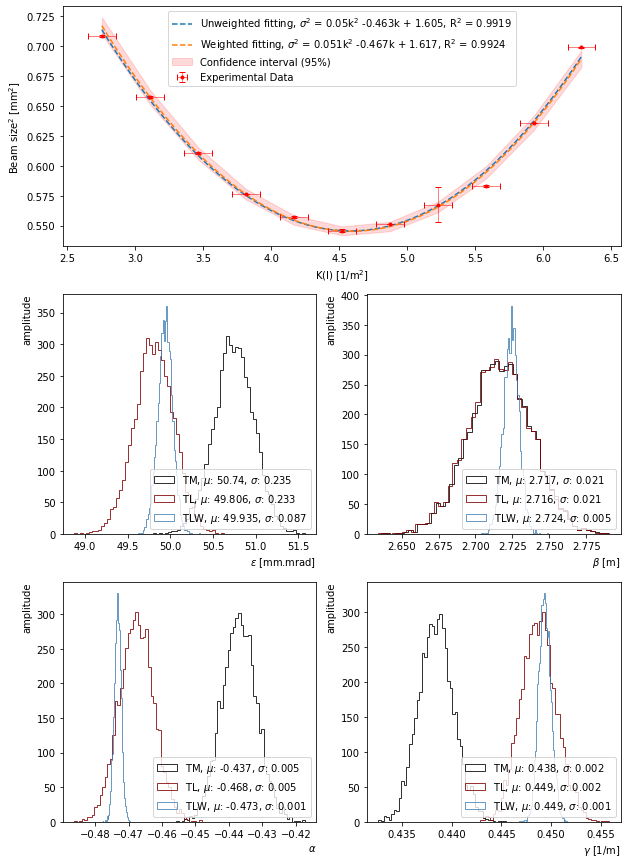

In [14]:
nemit_t, nemit_tl, nemit_tlw = emit_montec(energy, sigma, err_sigma, current, err_current, 'x', 5000, plot = True)

## Compare three methods differences in function of the number of samples M

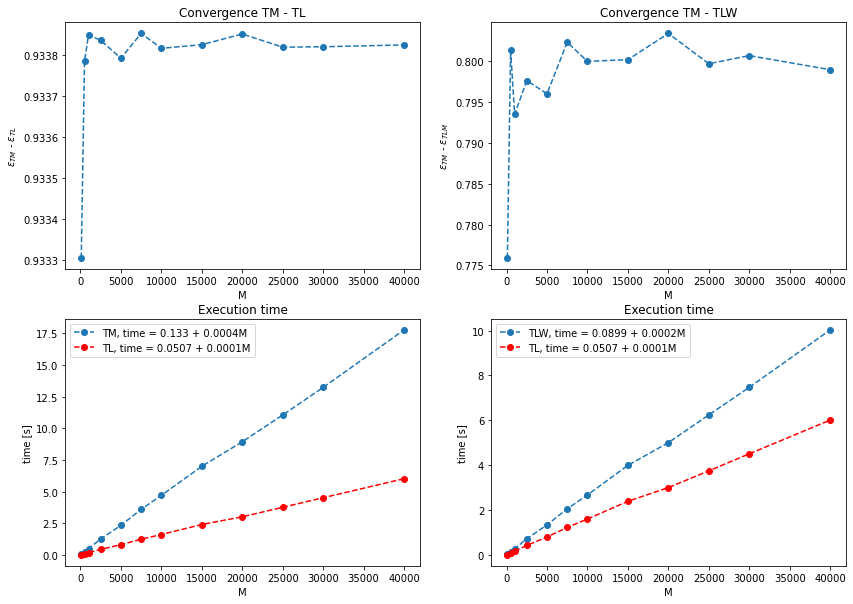

In [15]:
Ms = [100,500, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 30000, 40000]
x0s, y0s, y0s2 = [], [], []
times_t, times_tl, times_tlw = [], [], []

for k in Ms:
    nemit_t, nemit_tl, nemit_tlw, time_t, time_tl, time_tlw = emit_montec(energy, sigma,err_sigma, current, err_current, 'x', k, plot = False, times = True)
    y0s.append(np.abs(np.mean(nemit_t)- np.mean(nemit_tl)))
    y0s2.append(np.abs(np.mean(nemit_t)- np.mean(nemit_tlw)))
    times_t.append(time_t)
    times_tl.append(time_tl)
    times_tlw.append(time_tlw)
    
a1, b1 = np.polyfit(Ms,times_t, 1)
a2, b2 = np.polyfit(Ms,times_tl, 1)
a3, b3 = np.polyfit(Ms,times_tlw, 1)
fig = plt.figure(figsize=(14,10))
gs = GridSpec(2,2) # 1 rows, 2 columns
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax1.plot(Ms, y0s, "o--")
ax1.set_xlabel('M')
ax2.set_xlabel('M')
ax1.set_ylabel('$\epsilon_{TM}$ - $\epsilon_{TL}$')
ax2.set_ylabel('$\epsilon_{TM}$ - $\epsilon_{TLM}$')
ax2.plot(Ms, y0s2, "o--")
ax3.plot(Ms,times_t , "o--", label= 'TM, time = '+ str(round(b1, 4))+ ' + '+str(round(a1, 4))+'M')
ax3.plot(Ms,times_tl , "or--", label= 'TL, time = '+ str(round(b2, 4))+ ' + '+str(round(a2, 4))+'M')
ax4.plot(Ms,times_tlw , "o--", label= 'TLW, time = '+ str(round(b3, 4))+ ' + '+str(round(a3, 4))+'M')
ax4.plot(Ms,times_tl , "or--", label= 'TL, time = '+ str(round(b2, 4))+ ' + '+str(round(a2, 4))+'M')
ax3.set_xlabel('M')
ax4.set_xlabel('M')
ax3.set_ylabel('time [s]')
ax4.set_ylabel('time [s]')
ax1.set_title('Convergence TM - TL')
ax2.set_title('Convergence TM - TLW')
ax3.set_title('Execution time')
ax4.set_title('Execution time')
ax3.legend()
ax4.legend()
plt.show()

### Compare the mean of the sum of squared residuals eˆ2 in function of the number of samples M

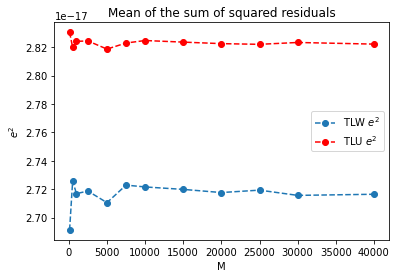

In [16]:
Ms = [100,500, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 25000, 30000, 40000]
eut, ewt = [], []
weights = 1/(2*np.array(err_sigma))**2
for m in Ms:
    eu, ew = [], []
    for j in range(m):
        sigma_mont_s = []
        I_mont_s = []
        for i in range(len(sigma)):
            sigma_mont_s.append(sigma[i] + err_sigma[i]*np.random.randn())
            I_mont_s.append(current[i]+ err_current[i]*np.random.randn())
        K1 = _get_K1_from_I(energy, I_mont_s)
        au, bu, cu = quadratic_fit(K1, np.array(sigma_mont_s)*sigma_mont_s)
        aw, bw, cw = quadratic_fit(K1, np.array(sigma_mont_s)*sigma_mont_s, weighted = True, ws = weights)
        # Residues
        residu = np.array(sigma)*sigma - (au + bu*K1 + cu*K1**2)
        residw = np.array(sigma)*sigma - (aw + bw*K1 + cw*K1**2)
        eu.append(np.mean(residu**2))
        ew.append(np.mean(residw**2))
    eut.append(np.mean(eu))
    ewt.append(np.mean(ew))

plt.plot(Ms, eut, "o--", label= 'TLW $e^2$')
plt.plot(Ms, ewt, "or--", label= 'TLU $e^2$')
plt.legend()
plt.xlabel('M')
plt.ylabel('$e^2$')
plt.title('Mean of the sum of squared residuals')
plt.show()